In [1]:
import pandas as pd
import numpy as np
import re
import requests
from numpy import std
from google.cloud import bigquery
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from collections import Counter, defaultdict

import ortools
import ortools.graph.pywrapgraph
from k_means_constrained import KMeansConstrained


import os
from collections import defaultdict

from joblib import dump, load

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from seaborn import heatmap
import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime
import itertools
import hdbscan

pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
bqclient = bigquery.Client()
query_string = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_kpi_20230330` as skpi
    WHERE skpi.sales_country = "germany"
"""
seller_base_df =  bqclient.query(query_string).result().to_dataframe()


seller_base_df.shape

(1110, 87)

In [3]:
seller_base_df.columns

Index(['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'is_fds', 'date_contract_end',
       'is_net_seller', 'tax_identification_number', 'corporate_name',
       'current_stage', 'seller_ranking', 'aggregator', 'article_potential',
       'article_go_live', 'gmv_potential_first_year', 'date_start_of_sales_fc',
       'is_lighthouse_partner', 'account_manager', 'business_developer',
       'technical_onboarding_manager', 'is_active_oci_seller',
       'is_gmv_relevant_for_current_year', 'date_contact', 'date_interest',
       'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active',
       'date_parking', 'date_lost', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'pu

In [4]:
seller_df = seller_base_df.copy()
seller_base_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,is_fds,date_contract_end,is_net_seller,tax_identification_number,corporate_name,current_stage,seller_ranking,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m
0,2000,Bauer Distribution,TERMINATED,germany,germany,False,2017-03-08,False,2021-11-11,False,DE132757274,Bauer Distribution GmbH,Lost,None,None,6500,<NA>,NaN,NaT,<NA>,Michael Knoth,Justin Röhrl,None,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,2001,Reidl,TERMINATED,germany,germany,False,2017-03-08,False,2019-09-19,False,DE315230966,Reidl GmbH & Co. KG,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,2002,Picotronic,TERMINATED,germany,germany,False,2017-03-08,False,2020-08-31,False,DE814473445,Picotronic GmbH,Closed,None,None,<NA>,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,2003,Torwegge GmbH & Co. KG,TERMINATED,germany,germany,False,2017-03-08,False,2022-08-31,False,DE126942199,TORWEGGE GmbH & Co. KG,Closed,None,JTL,4000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216
4,2004,Beckmann Elektronik GmbH,TERMINATED,germany,germany,False,2017-03-09,False,2022-04-30,False,DE813330112,Beckmann Elektronik GmbH,Closed,None,None,1000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [5]:
drop_cols = ['shop_id', 'shop_name', 'sales_country',  'origin_country', 'is_crossborder', 'is_net_seller', 'tax_identification_number']
boolean_cols = ['is_fds', 'is_lighthouse_partner', 'is_active_oci_seller', 'is_gmv_relevant_for_current_year', ]

In [6]:
seller_base_df.drop(columns=drop_cols, axis=1, inplace=True)


In [7]:
seller_base_df.is_gmv_relevant_for_current_year.value_counts()

True     26
False    20
Name: is_gmv_relevant_for_current_year, dtype: Int64

In [8]:
seller_base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 80 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   shop_state                        1110 non-null   object 
 1   date_created                      1110 non-null   dbdate 
 2   is_fds                            1110 non-null   boolean
 3   date_contract_end                 242 non-null    dbdate 
 4   corporate_name                    1107 non-null   object 
 5   current_stage                     1008 non-null   object 
 6   seller_ranking                    840 non-null    object 
 7   aggregator                        226 non-null    object 
 8   article_potential                 914 non-null    Int64  
 9   article_go_live                   197 non-null    Int64  
 10  gmv_potential_first_year          564 non-null    float64
 11  date_start_of_sales_fc            435 non-null    dbdate 
 12  is_lig

In [9]:
seller_base_df.seller_ranking.unique()

array([None, 'B', 'C', 'A'], dtype=object)

In [10]:
seller_base_df['seller_ranking'].fillna("Other", inplace=True)

seller_base_df = pd.concat([seller_base_df, pd.get_dummies(seller_base_df["seller_ranking"],prefix="seller_ranking_cat_")], axis=1)
seller_base_df.drop(columns=["seller_ranking"], axis=1, inplace=True)

seller_base_df.head()

,shop_state,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other
0,TERMINATED,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,Lost,None,6500,<NA>,NaN,NaT,<NA>,Michael Knoth,Justin Röhrl,None,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1
1,TERMINATED,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1
2,TERMINATED,2017-03-08,False,2020-08-31,Picotronic GmbH,Closed,None,<NA>,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1
3,TERMINATED,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,Closed,JTL,4000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,0,0,0,1
4,TERMINATED,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,Closed,None,1000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1


In [11]:
seller_base_df.current_stage.unique()

array(['Lost', None, 'Closed', 'Won Active', 'Parking', 'Onboarding',
       'Contact', 'Interest', 'Pool', 'Won KYC'], dtype=object)

In [12]:
seller_base_df['current_stage'].fillna("Nan", inplace=True)
seller_base_df.current_stage.unique()

array(['Lost', 'Nan', 'Closed', 'Won Active', 'Parking', 'Onboarding',
       'Contact', 'Interest', 'Pool', 'Won KYC'], dtype=object)

In [13]:

stage_dictionary = dict(zip(seller_base_df['current_stage'].unique() , np.arange(1, len(seller_base_df['current_stage'].unique()) + 1, 1).tolist()))
seller_base_df['current_stage'] = seller_base_df['current_stage'].map(stage_dictionary)

seller_base_df.current_stage.value_counts()

4     556
3     191
2     102
6     100
1     69 
10    59 
5     23 
8     5  
7     3  
9     2  
Name: current_stage, dtype: int64

In [14]:
seller_base_df['shop_state'].unique()

array(['TERMINATED', 'SUSPENDED', 'OPEN', 'CLOSE'], dtype=object)

In [15]:
seller_base_df = pd.concat([seller_base_df, pd.get_dummies(seller_base_df["shop_state"],prefix="shop_state_cat_")], axis=1)
seller_base_df.drop(columns=["shop_state"], axis=1, inplace=True)

seller_base_df.head()

,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,None,6500,<NA>,NaN,NaT,<NA>,Michael Knoth,Justin Röhrl,None,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,None,<NA>,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,JTL,4000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,None,1000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [16]:
seller_base_df['aggregator'].unique()

array([None, 'JTL', 'Plentymarkets', 'Channel Advisor', 'Tradebyte',
       'Shopware', 'Magento', 'Channel Engine', 'eVolution',
       'Speed4Trade', 'Channelpilot', 'Brickfox', 'Lengow', 'Channable',
       'Nordwest Dataconnect', 'Shopify', 'API', 'SAP', 'Keine Angabe'],
      dtype=object)

In [17]:
seller_base_df['aggregator'].fillna("Other", inplace=True)

aggregator_dictionary = dict(zip(seller_base_df['aggregator'].unique() , np.arange(1, len(seller_base_df['aggregator'].unique()) + 1, 1).tolist()))
seller_base_df['aggregator'] = seller_base_df['aggregator'].map(aggregator_dictionary)
#seller_base_df['aggregator'] = seller_base_df['aggregator'].replace(aggregator_dict.keys(), aggregator_dict.values())
seller_base_df['aggregator'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

<AxesSubplot:>

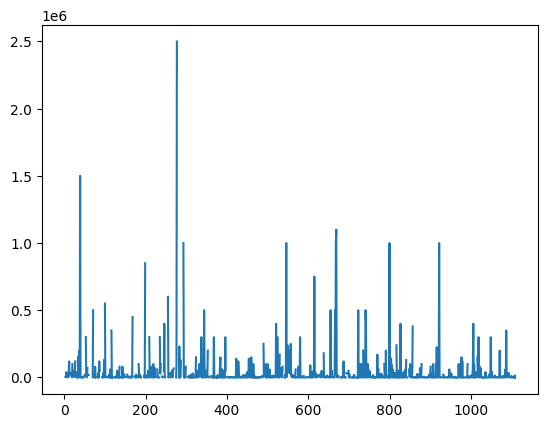

In [18]:
seller_base_df.article_potential.plot()

In [19]:
seller_base_df.article_potential.min(), seller_base_df.article_potential.mean(), std(seller_base_df.article_potential), seller_base_df.article_potential.max()


(1, 42902.65098468271, 149818.47375076407, 2500000)

<AxesSubplot:>

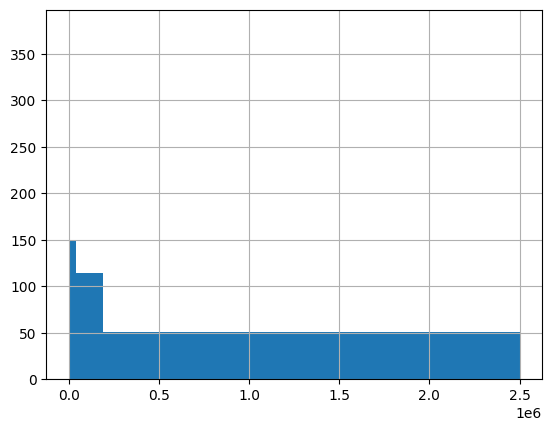

In [20]:
#seller_base_df['article_potential'].fillna(0, inplace=True)

article_potential_bins = [-1, seller_base_df.article_potential.min(), 1000, 10000, seller_base_df.article_potential.mean(), seller_base_df.article_potential.mean() + std(seller_base_df.article_potential), seller_base_df.article_potential.max() +1 ]
seller_base_df.article_potential.hist(bins=article_potential_bins)


In [21]:
len(article_potential_bins), seller_base_df.article_potential.value_counts(bins=article_potential_bins)


(7,
 (1.0, 1000.0]              416
 (1000.0, 10000.0]          208
 (10000.0, 42902.651]       118
 (42902.651, 192721.125]    114
 (192721.125, 2500001.0]    51 
 (-1.001, 1.0]              7  
 Name: article_potential, dtype: int64)

In [22]:
seller_base_df['article_potential'] = pd.cut(seller_base_df.article_potential, article_potential_bins).cat.codes
seller_base_df['article_potential'].unique()

array([ 2, -1,  1,  3,  4,  5,  0], dtype=int8)

In [23]:
seller_base_df['article_potential'].value_counts()

 1    416
 2    208
-1    196
 3    118
 4    114
 5    51 
 0    7  
Name: article_potential, dtype: int64

In [24]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]


In [25]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins

In [26]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)

In [27]:
seller_base_df.article_go_live.min(), seller_base_df.article_go_live.mean(), std(seller_base_df.article_go_live), seller_base_df.article_go_live.max()


(1, 8257.243654822336, 20548.786747233324, 150000)

In [28]:
seller_base_df.article_go_live.min(), seller_base_df.article_go_live.mean(), std(seller_base_df.article_go_live), seller_base_df.article_go_live.max()


(1, 8257.243654822336, 20548.786747233324, 150000)

<AxesSubplot:>

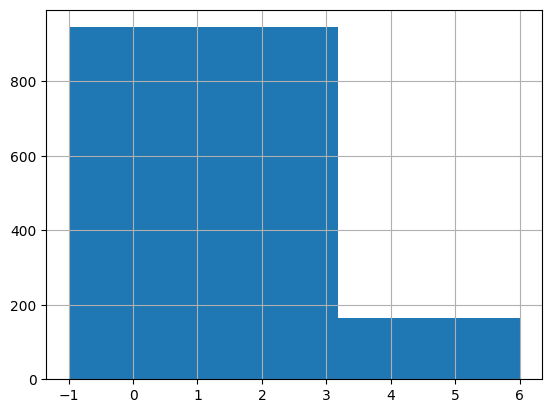

In [29]:
article_potential_bins = [-1, seller_base_df.article_potential.min(), seller_base_df.article_potential.mean() + std(seller_base_df.article_potential), seller_base_df.article_potential.max() +1 ]
seller_base_df.article_potential.hist(bins=article_potential_bins)

## article_go_live

In [30]:
seller_base_df.article_go_live.min(), seller_base_df.article_go_live.mean(), std(seller_base_df.article_go_live), seller_base_df.article_go_live.max()


(1, 8257.243654822336, 20548.786747233324, 150000)

<AxesSubplot:>

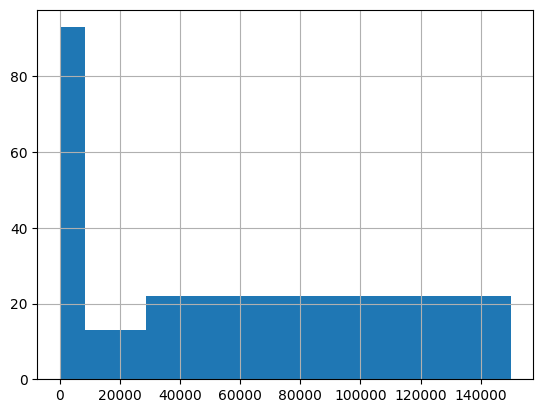

In [31]:
article_go_live_bins = [-1, seller_base_df.article_go_live.min(), 100, seller_base_df.article_go_live.mean(), seller_base_df.article_go_live.mean() + std(seller_base_df.article_go_live), seller_base_df.article_go_live.max() +1 ]
seller_base_df.article_go_live.hist(bins=article_go_live_bins)

In [32]:
seller_base_df.article_go_live.value_counts(bins=article_go_live_bins)


(100.0, 8257.244]       86
(1.0, 100.0]            69
(28806.03, 150001.0]    22
(8257.244, 28806.03]    13
(-1.001, 1.0]           7 
Name: article_go_live, dtype: int64

In [33]:
seller_base_df['article_go_live'] = pd.cut(seller_base_df.article_go_live, article_go_live_bins).cat.codes
seller_base_df['article_go_live'].unique()

array([-1,  2,  1,  3,  4,  0], dtype=int8)

In [34]:
seller_base_df['article_go_live'].value_counts()

-1    913
 2    86 
 1    69 
 4    22 
 3    13 
 0    7  
Name: article_go_live, dtype: int64

In [35]:
boolean_dict = {True: 1, False:0, "Other":99, "<NA>":99, "NA":99, "nan": 99, "NaN": 99, None: 99}
def convert_boolean_cols(df , col, boolean_dict):
    df[col].fillna("Other", inplace=True)
    df[col] = df[col].map(boolean_dict)
    return df

In [36]:
boolean_cols

['is_fds',
 'is_lighthouse_partner',
 'is_active_oci_seller',
 'is_gmv_relevant_for_current_year']

# gmv_potential_first_year

In [37]:
seller_base_df['gmv_potential_first_year'].min(), seller_base_df['gmv_potential_first_year'].mean(), std(seller_base_df['gmv_potential_first_year']),seller_base_df['gmv_potential_first_year'].max()


(5.0, 60060.08865248227, 181448.9355333831, 3000000.0)

<AxesSubplot:>

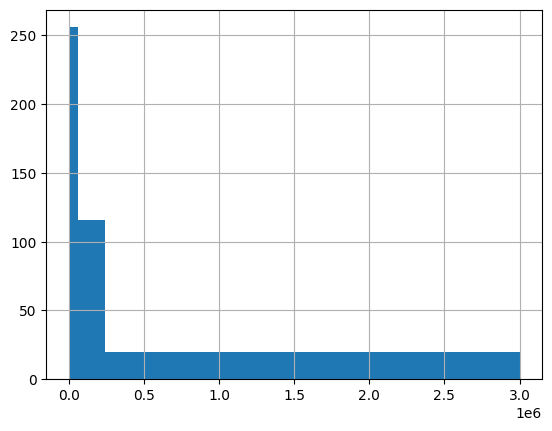

In [38]:
gmv_potential_first_year_bins = [-1, seller_base_df.gmv_potential_first_year.min(), 1000, 10000, seller_base_df.gmv_potential_first_year.mean(), seller_base_df.gmv_potential_first_year.mean() + std(seller_base_df.gmv_potential_first_year), seller_base_df.gmv_potential_first_year.max() +1 ]
seller_base_df.gmv_potential_first_year.hist(bins=gmv_potential_first_year_bins)

In [39]:
seller_base_df.gmv_potential_first_year.value_counts(bins=gmv_potential_first_year_bins)

(1000.0, 10000.0]          196
(10000.0, 60060.089]       183
(60060.089, 241509.024]    116
(5.0, 1000.0]              48 
(241509.024, 3000001.0]    20 
(-1.001, 5.0]              1  
Name: gmv_potential_first_year, dtype: int64

In [40]:
seller_base_df['gmv_potential_first_year'] = pd.cut(seller_base_df.gmv_potential_first_year, gmv_potential_first_year_bins).cat.codes
seller_base_df['gmv_potential_first_year'].value_counts()


-1    546
 2    196
 3    183
 4    116
 1    48 
 5    20 
 0    1  
Name: gmv_potential_first_year, dtype: int64

In [41]:
seller_base_df.offers_inactive_mp.unique()

<IntegerArray>
[   13,     0,  2925,   247,  7153,    69,   208,  1422,  1188,     9,
 ...
 15121, 10945,   230,    41, 17000,   201,    27,    37,  3798,  2519]
Length: 342, dtype: Int64

In [42]:
seller_base_df.head()

,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,<NA>,Michael Knoth,Justin Röhrl,None,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [43]:
seller_base_df['account_manager'].value_counts()


Diana Egriderlieva       225
DSM (digital managed)    175
Tatiana Vakalov          55 
Michael Knoth            53 
Christian Zens           52 
Alexander Djordjevic     52 
Inga Scheithauer         36 
Eugen Schwab             32 
Silke Luitjens           11 
Jonas Tischler           8  
Name: account_manager, dtype: int64

In [44]:
seller_base_df['business_developer'].value_counts()


Tobias Wutz                   237
Tom Schneider                 189
Justin Röhrl                  180
Dominik Göltner               155
Dirk Grzeganek                155
Laura Breiling                43 
Augusto Dalferth Sossmeier    29 
Melanie Beck                  14 
Andreas Kummer                5  
Name: business_developer, dtype: int64

In [45]:
seller_base_df['technical_onboarding_manager'].value_counts()


Dirk Grzeganek            107
Jonas Tischler            101
Daniel Kunz               85 
Lukas Schregelmann        44 
Stephan Jäntsch           41 
Sabine Vargas-Avendano    24 
Antonio Esposito          16 
Iryna Dolynska            11 
Name: technical_onboarding_manager, dtype: int64

# account_manager, business_developer

In [46]:
stakeholder_cols = ['account_manager', 'business_developer', 'technical_onboarding_manager']

for col in stakeholder_cols:
    print(col)
    param_dict = dict(zip(seller_base_df[col].unique() , np.arange(1, len(seller_base_df[col].unique()) + 1, 1).tolist()))
    print(len(param_dict))
    seller_base_df[col] = seller_base_df[col].map(param_dict)

seller_base_df.head()

account_manager
11
business_developer
10
technical_onboarding_manager
9


,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,<NA>,1,1,1,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,<NA>,2,2,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,<NA>,3,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,<NA>,4,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,<NA>,4,4,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


# days_in_technical_onboarding

In [47]:
seller_base_df.days_in_technical_onboarding.min(), seller_base_df.days_in_technical_onboarding.mean(), seller_base_df.days_in_technical_onboarding.max(), std(seller_base_df.days_in_technical_onboarding)


(8, 105.92924528301887, 729, 118.3961597947644)

<AxesSubplot:>

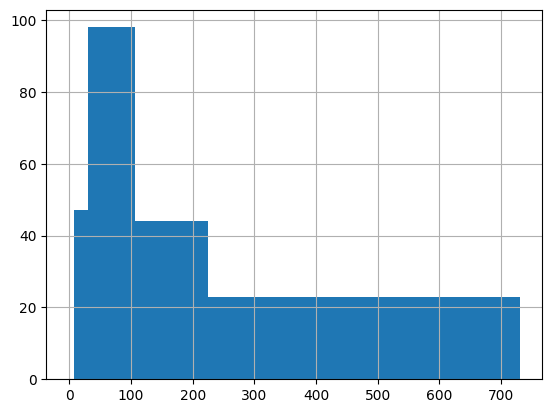

In [48]:
days_in_technical_onboarding_bins = [-1, seller_base_df.days_in_technical_onboarding.min(), 30, seller_base_df.days_in_technical_onboarding.mean(), seller_base_df.days_in_technical_onboarding.mean() + std(seller_base_df.days_in_technical_onboarding), seller_base_df.days_in_technical_onboarding.max() +1 ]
seller_base_df.days_in_technical_onboarding.hist(bins=days_in_technical_onboarding_bins)


In [49]:
seller_base_df.days_in_technical_onboarding.value_counts(bins=days_in_technical_onboarding_bins)

(30.0, 105.929]       98
(8.0, 30.0]           44
(105.929, 224.325]    44
(224.325, 730.0]      23
(-1.001, 8.0]         3 
Name: days_in_technical_onboarding, dtype: int64

In [50]:
seller_base_df['days_in_technical_onboarding'] = pd.cut(seller_base_df.days_in_technical_onboarding, days_in_technical_onboarding_bins).cat.codes
seller_base_df['days_in_technical_onboarding'].value_counts()


-1    898
 2    98 
 1    44 
 3    44 
 4    23 
 0    3  
Name: days_in_technical_onboarding, dtype: int64

# days_to_first_sale

In [51]:
seller_base_df.days_to_first_sale.min(), seller_base_df.days_to_first_sale.mean(), seller_base_df.days_to_first_sale.max(), std(seller_base_df.days_to_first_sale)


(-572, -2.830508474576271, 959, 146.34008218785843)

<AxesSubplot:>

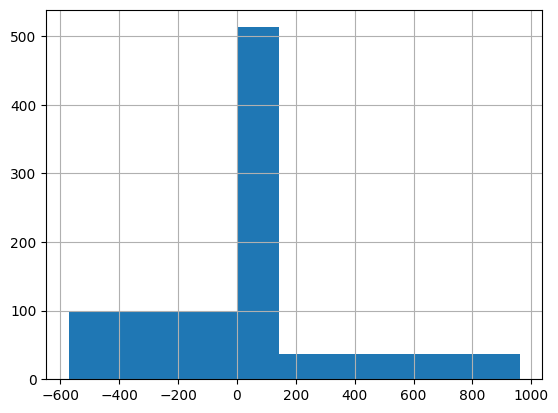

In [52]:
days_to_first_sale_bins = [seller_base_df.days_to_first_sale.min(), 0, seller_base_df.days_to_first_sale.mean() + std(seller_base_df.days_to_first_sale), seller_base_df.days_to_first_sale.max() +1 ]
seller_base_df.days_to_first_sale.hist(bins=days_to_first_sale_bins)

In [53]:
seller_base_df.days_to_first_sale.value_counts(bins=days_to_first_sale_bins)

(0.0, 143.51]      468
(-572.001, 0.0]    144
(143.51, 960.0]    37 
Name: days_to_first_sale, dtype: int64

In [54]:
seller_base_df['days_to_first_sale'] = pd.cut(seller_base_df.days_to_first_sale, days_to_first_sale_bins).cat.codes
seller_base_df['days_to_first_sale'].value_counts()

 1    468
-1    462
 0    143
 2    37 
Name: days_to_first_sale, dtype: int64

# offers_active_mp, offers_inactive_mp

In [55]:
seller_base_df.offers_active_mp.min(), seller_base_df.offers_active_mp.mean(), seller_base_df.offers_active_mp.max(), std(seller_base_df.offers_active_mp)


(0, 7227.736036036036, 479757, 37635.80115209523)

In [56]:
seller_base_df.offers_inactive_mp.min(), seller_base_df.offers_inactive_mp.mean(), seller_base_df.offers_inactive_mp.max(), std(seller_base_df.offers_inactive_mp)


(0, 3855.766666666667, 918752, 33589.654061828376)

In [57]:
seller_base_df.offers_active_oci.min(), seller_base_df.offers_active_oci.mean(), seller_base_df.offers_active_oci.max(), std(seller_base_df.offers_active_oci)


(0, 3610.0243243243244, 440794, 32479.89405138967)

In [58]:

seller_base_df.offers_inactive_oci.min(), seller_base_df.offers_inactive_oci.mean(), seller_base_df.offers_inactive_oci.max(), std(seller_base_df.offers_inactive_oci)


(0, 1137.6396396396397, 554764, 18245.48678272545)

<AxesSubplot:>

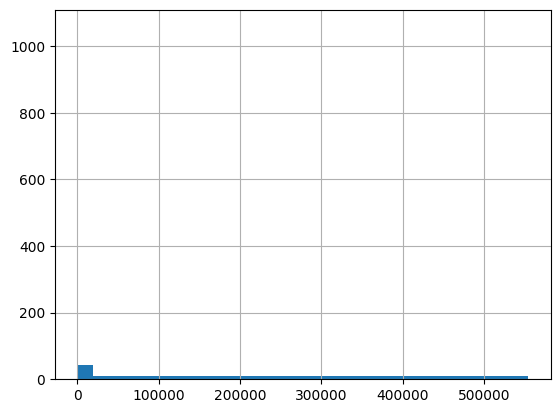

In [59]:
offers_inactive_oci_bins = [seller_base_df.offers_inactive_oci.min(),10, seller_base_df.offers_inactive_oci.mean() + std(seller_base_df.offers_inactive_oci), seller_base_df.offers_inactive_oci.max() +1 ]
seller_base_df.offers_inactive_oci.hist(bins=offers_inactive_oci_bins)

<AxesSubplot:>

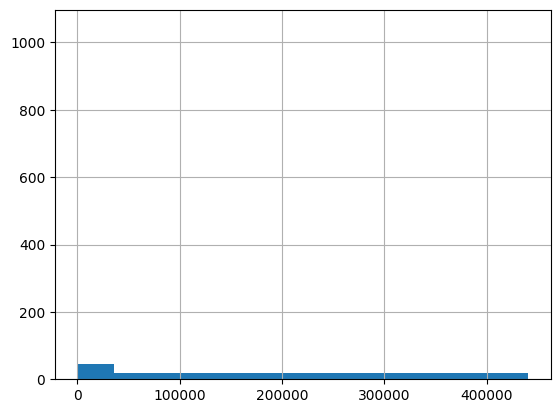

In [60]:
offers_active_oci_bins = [seller_base_df.offers_active_oci.min(),1, 10, seller_base_df.offers_active_oci.mean() + std(seller_base_df.offers_active_oci), seller_base_df.offers_active_oci.max() +1 ]
seller_base_df.offers_active_oci.hist(bins=offers_active_oci_bins)

In [61]:
seller_base_df.offers_active_oci.value_counts(bins=offers_active_oci_bins)

(-0.001, 1.0]            1045
(10.0, 36089.918]        46  
(36089.918, 440795.0]    19  
(1.0, 10.0]              0   
Name: offers_active_oci, dtype: int64

In [62]:
seller_base_df.offers_inactive_oci.value_counts(bins=offers_inactive_oci_bins)

(-0.001, 10.0]           1057
(10.0, 19383.126]        43  
(19383.126, 554765.0]    10  
Name: offers_inactive_oci, dtype: int64

<AxesSubplot:>

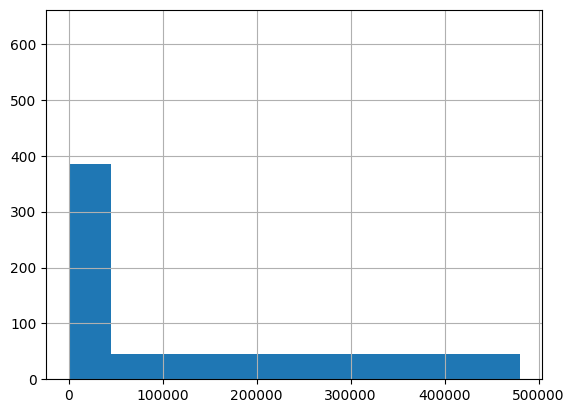

In [63]:
offers_active_mp_bins = [seller_base_df.offers_active_mp.min(),1 , 10, seller_base_df.offers_active_mp.mean() + std(seller_base_df.offers_active_mp), seller_base_df.offers_active_mp.max() +1 ]
seller_base_df.offers_active_mp.hist(bins=offers_active_mp_bins)

<AxesSubplot:>

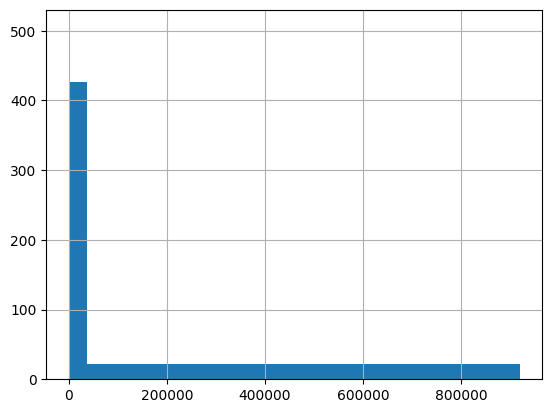

In [64]:
offers_inactive_mp_bins = [seller_base_df.offers_inactive_mp.min(),1 , 10, seller_base_df.offers_inactive_mp.mean() + std(seller_base_df.offers_inactive_mp), seller_base_df.offers_inactive_mp.max() +1 ]
seller_base_df.offers_inactive_mp.hist(bins=offers_inactive_mp_bins)

In [65]:
seller_base_df.offers_active_mp.value_counts(bins=offers_active_mp_bins)

(-0.001, 1.0]            640
(10.0, 44863.537]        382
(44863.537, 479758.0]    46 
(1.0, 10.0]              42 
Name: offers_active_mp, dtype: int64

In [66]:
seller_base_df.offers_inactive_mp.value_counts(bins=offers_inactive_mp_bins)

(-0.001, 1.0]            556
(10.0, 37445.421]        418
(1.0, 10.0]              114
(37445.421, 918753.0]    22 
Name: offers_inactive_mp, dtype: int64

offers_active_mp
offers_inactive_mp
offers_active_oci
offers_inactive_oci


,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,<NA>,1,1,1,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,-1,0,-1,2,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,<NA>,2,2,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,<NA>,3,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,<NA>,4,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,-1,0,-1,2,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,<NA>,4,4,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,-1,0,-1,2,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


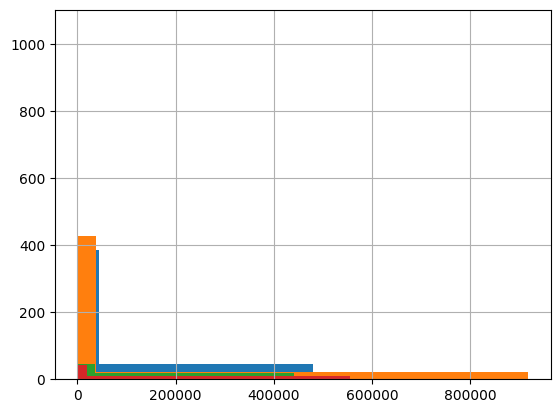

In [67]:
offer_cols = ['offers_active_mp', 'offers_inactive_mp', 'offers_active_oci', 'offers_inactive_oci']
for col in offer_cols:
    print(col)
    offer_bins = [seller_base_df[col].min(),1, 10, seller_base_df[col].mean() + std(seller_base_df[col]), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [68]:
seller_base_df.purchased_offers_mp_1m.min(), seller_base_df.purchased_offers_mp_1m.mean(), seller_base_df.purchased_offers_mp_1m.max(), std(seller_base_df.purchased_offers_mp_1m)


(0, 32.067567567567565, 4481, 177.9063371664798)

In [69]:
#purchased_offers_oci_1m
seller_base_df.purchased_offers_oci_1m.min(), seller_base_df.purchased_offers_oci_1m.mean(), seller_base_df.purchased_offers_oci_1m.max(), std(seller_base_df.purchased_offers_oci_1m)



(0, 12.690990990990992, 2441, 109.50884208781652)

In [70]:
#purchased_offers_mp_6m
seller_base_df.purchased_offers_mp_6m.min(), seller_base_df.purchased_offers_mp_6m.mean(), seller_base_df.purchased_offers_mp_6m.max(), std(seller_base_df.purchased_offers_mp_6m)



(0, 128.74054054054054, 17843, 700.1937436358132)

<AxesSubplot:>

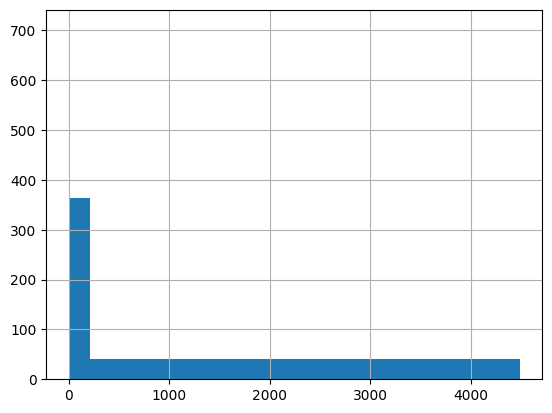

In [71]:
purchased_offers_mp_1m_bins = [seller_base_df.purchased_offers_mp_1m.min(), 1, seller_base_df.purchased_offers_mp_1m.mean() + std(seller_base_df.purchased_offers_mp_1m), seller_base_df.purchased_offers_mp_1m.max() +1 ]
seller_base_df.purchased_offers_mp_1m.hist(bins=purchased_offers_mp_1m_bins)


In [72]:
seller_base_df.purchased_offers_mp_1m.value_counts(bins=purchased_offers_mp_1m_bins)

(-0.001, 1.0]        741
(1.0, 209.974]       329
(209.974, 4482.0]    40 
Name: purchased_offers_mp_1m, dtype: int64

In [73]:
purchased_offers_mp_cols = ['purchased_offers_mp_1m', 'purchased_offers_mp_3m' , 'purchased_offers_mp_6m']
purchased_offers_oci_cols = ['purchased_offers_oci_1m', 'purchased_offers_oci_3m' , 'purchased_offers_oci_6m']
#####
purchased_products_mp_cols = ['purchased_products_mp_1m', 'purchased_products_mp_3m' , 'purchased_products_mp_6m']
purchased_products_oci_cols = ['purchased_products_oci_1m', 'purchased_products_oci_3m' , 'purchased_products_oci_6m']
#####
customers_mp_cols = ['customers_mp_1m', 'customers_mp_3m' , 'customers_mp_6m']
customers_oci_cols = ['customers_oci_1m', 'customers_oci_3m' , 'customers_oci_6m']
#####
#####
orders_mp_cols = ['orders_mp_1m', 'orders_mp_3m' , 'orders_mp_6m']
orders_oci_cols = ['orders_oci_1m', 'orders_oci_3m' , 'orders_oci_6m']
#####
ordered_units_mp_cols = ['ordered_units_mp_1m', 'ordered_units_mp_3m' , 'ordered_units_mp_6m']
ordered_units_oci_cols = ['ordered_units_oci_1m', 'ordered_units_oci_3m' , 'ordered_units_oci_6m']
#####
sales_mp_cols = ['sales_mp_1m', 'sales_mp_3m' , 'sales_mp_6m']
sales_oci_cols = ['sales_oci_1m', 'sales_oci_3m' , 'sales_oci_6m']
#####
#####
commission_mp_cols = ['commission_mp_1m', 'commission_mp_3m' , 'commission_mp_6m']
pdpv_mp_active_cols = ['pdpv_mp_active_1m', 'pdpv_mp_active_3m' , 'pdpv_mp_active_6m']
#####
pdpv_mp_inactive_cols = ['pdpv_mp_inactive_1m', 'pdpv_mp_inactive_3m' , 'pdpv_mp_inactive_6m']



In [74]:
periodic_cols = ['purchased_offers_mp_1m', 'purchased_offers_mp_3m' , 'purchased_offers_mp_6m',
                 'purchased_offers_oci_1m', 'purchased_offers_oci_3m' , 'purchased_offers_oci_6m',
                 'purchased_products_mp_1m', 'purchased_products_mp_3m' , 'purchased_products_mp_6m',
                 'purchased_products_oci_1m', 'purchased_products_oci_3m' , 'purchased_products_oci_6m',
                 'customers_mp_1m', 'customers_mp_3m' , 'customers_mp_6m',
                 'customers_oci_1m', 'customers_oci_3m' , 'customers_oci_6m',
                 'orders_mp_1m', 'orders_mp_3m' , 'orders_mp_6m',
                 'ordered_units_mp_1m', 'ordered_units_mp_3m' , 'ordered_units_mp_6m',
                 'ordered_units_oci_1m', 'ordered_units_oci_3m' , 'ordered_units_oci_6m', 
                 'sales_mp_1m', 'sales_mp_3m' , 'sales_mp_6m',
                 'sales_oci_1m', 'sales_oci_3m' , 'sales_oci_6m',
                 'commission_mp_1m', 'commission_mp_3m' , 'commission_mp_6m',
                 'pdpv_mp_active_1m', 'pdpv_mp_active_3m' , 'pdpv_mp_active_6m',
                 'pdpv_mp_inactive_1m', 'pdpv_mp_inactive_3m' , 'pdpv_mp_inactive_6m']

purchased_offers_mp_1m
purchased_offers_mp_3m
purchased_offers_mp_6m
purchased_offers_oci_1m
purchased_offers_oci_3m
purchased_offers_oci_6m
purchased_products_mp_1m
purchased_products_mp_3m
purchased_products_mp_6m
purchased_products_oci_1m
purchased_products_oci_3m
purchased_products_oci_6m
customers_mp_1m
customers_mp_3m
customers_mp_6m
customers_oci_1m
customers_oci_3m
customers_oci_6m
orders_mp_1m
orders_mp_3m
orders_mp_6m
ordered_units_mp_1m
ordered_units_mp_3m
ordered_units_mp_6m
ordered_units_oci_1m
ordered_units_oci_3m
ordered_units_oci_6m
sales_mp_1m
sales_mp_3m
sales_mp_6m
sales_oci_1m
sales_oci_3m
sales_oci_6m
commission_mp_1m
commission_mp_3m
commission_mp_6m
pdpv_mp_active_1m
pdpv_mp_active_3m
pdpv_mp_active_6m
pdpv_mp_inactive_1m
pdpv_mp_inactive_3m
pdpv_mp_inactive_6m
CPU times: user 291 ms, sys: 8.24 ms, total: 300 ms
Wall time: 289 ms


,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,<NA>,1,1,1,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,<NA>,2,2,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,<NA>,3,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,<NA>,4,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,<NA>,4,4,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1


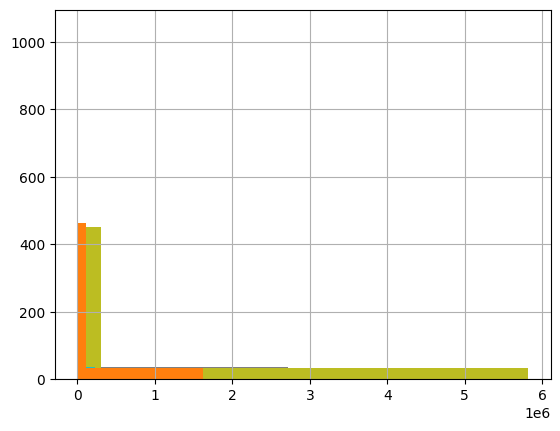

In [75]:
%%time
for col in periodic_cols:
    print(col)
    offer_bins = [seller_base_df[col].min(),1, seller_base_df[col].mean() + std(seller_base_df[col]), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [76]:
%%time
for col in periodic_cols:
    print(col)
    print(seller_base_df[col].value_counts())

purchased_offers_mp_1m
-1    706
 1    329
 2    40 
 0    35 
Name: purchased_offers_mp_1m, dtype: int64
purchased_offers_mp_3m
-1    669
 1    376
 2    43 
 0    22 
Name: purchased_offers_mp_3m, dtype: int64
purchased_offers_mp_6m
-1    636
 1    404
 2    39 
 0    31 
Name: purchased_offers_mp_6m, dtype: int64
purchased_offers_oci_1m
-1    1043
 1    37  
 2    27  
 0    3   
Name: purchased_offers_oci_1m, dtype: int64
purchased_offers_oci_3m
-1    1043
 1    40  
 2    27  
Name: purchased_offers_oci_3m, dtype: int64
purchased_offers_oci_6m
-1    1043
 1    42  
 2    25  
Name: purchased_offers_oci_6m, dtype: int64
purchased_products_mp_1m
-1    709
 1    326
 2    40 
 0    35 
Name: purchased_products_mp_1m, dtype: int64
purchased_products_mp_3m
-1    672
 1    373
 2    43 
 0    22 
Name: purchased_products_mp_3m, dtype: int64
purchased_products_mp_6m
-1    639
 1    400
 2    40 
 0    31 
Name: purchased_products_mp_6m, dtype: int64
purchased_products_oci_1m
-1    1043
 

In [77]:
boolean_cols

['is_fds',
 'is_lighthouse_partner',
 'is_active_oci_seller',
 'is_gmv_relevant_for_current_year']

In [78]:
seller_base_df.head()

,date_created,is_fds,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED
0,2017-03-08,False,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,<NA>,1,1,1,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
1,2017-03-08,False,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,<NA>,2,2,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
2,2017-03-08,False,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,<NA>,3,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1
3,2017-03-08,False,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,<NA>,4,3,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1
4,2017-03-09,False,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,<NA>,4,4,1,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1


In [79]:
for col in boolean_cols:
    print(col)
    print(seller_base_df[col].value_counts())

is_fds
False    1037
True     73  
Name: is_fds, dtype: Int64
is_lighthouse_partner
True     126
False    91 
Name: is_lighthouse_partner, dtype: Int64
is_active_oci_seller
False    54
Name: is_active_oci_seller, dtype: Int64
is_gmv_relevant_for_current_year
True     26
False    20
Name: is_gmv_relevant_for_current_year, dtype: Int64


In [80]:
seller_base_df['is_fds_v2'] = False
seller_base_df['is_lighthouse_partner_v2'] = False
seller_base_df['is_active_oci_seller_v2'] = False
seller_base_df['is_gmv_relevant_for_current_year_v2'] = False
###
seller_base_df.loc[seller_base_df['is_fds'] == True, 'is_fds_v2'] = True
seller_base_df.loc[seller_base_df['is_lighthouse_partner'] == True, 'is_lighthouse_partner_v2'] = True
seller_base_df.loc[seller_base_df['is_active_oci_seller'] == True, 'is_active_oci_seller_v2'] = True
seller_base_df.loc[seller_base_df['is_gmv_relevant_for_current_year'] == True, 'is_gmv_relevant_for_current_year_v2'] = True
###
#seller_base_df = seller_base_df.drop(columns=boolean_cols)
seller_base_df.drop(columns=boolean_cols, axis=1, inplace=True)



In [81]:
seller_base_df.head()

,date_created,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,account_manager,business_developer,technical_onboarding_manager,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED,is_fds_v2,is_lighthouse_partner_v2,is_active_oci_seller_v2,is_gmv_relevant_for_current_year_v2
0,2017-03-08,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,1,1,1,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,False,False,False,False
1,2017-03-08,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,2,2,1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,False,False,False,False
2,2017-03-08,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,3,3,1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,False,False,False,False
3,2017-03-08,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,4,3,1,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1,False,False,False,False
4,2017-03-09,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,4,4,1,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,False,False,False,False


In [82]:
boolean_cols_v2 = ['is_fds_v2',
 'is_lighthouse_partner_v2',
 'is_active_oci_seller_v2',
 'is_gmv_relevant_for_current_year_v2']

In [83]:
for col in boolean_cols_v2:
    seller_base_df[col].fillna("Other", inplace=True)
    seller_base_df[col] = seller_base_df[col].map(boolean_dict)
    seller_base_df[col].value_counts()

In [84]:
seller_base_df.head()

,date_created,date_contract_end,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,account_manager,business_developer,technical_onboarding_manager,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED,is_fds_v2,is_lighthouse_partner_v2,is_active_oci_seller_v2,is_gmv_relevant_for_current_year_v2
0,2017-03-08,2021-11-11,Bauer Distribution GmbH,1,1,2,-1,-1,NaT,1,1,1,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0
1,2017-03-08,2019-09-19,Reidl GmbH & Co. KG,2,1,-1,-1,-1,NaT,2,2,1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0
2,2017-03-08,2020-08-31,Picotronic GmbH,3,1,-1,-1,-1,NaT,3,3,1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0
3,2017-03-08,2022-08-31,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,NaT,4,3,1,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0
4,2017-03-09,2022-04-30,Beckmann Elektronik GmbH,3,1,1,-1,-1,NaT,4,4,1,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0


In [85]:
for col in boolean_cols_v2:
    print(col)
    print(seller_base_df[col].value_counts())

is_fds_v2
0    1037
1    73  
Name: is_fds_v2, dtype: int64
is_lighthouse_partner_v2
0    984
1    126
Name: is_lighthouse_partner_v2, dtype: int64
is_active_oci_seller_v2
0    1110
Name: is_active_oci_seller_v2, dtype: int64
is_gmv_relevant_for_current_year_v2
0    1084
1    26  
Name: is_gmv_relevant_for_current_year_v2, dtype: int64


In [86]:
date_cols = ['date_created', 'date_contract_end', 'date_start_of_sales_fc', 'date_contact', 'date_interest', 
             'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active', 'date_parking', 
             'date_lost', 'date_first_open', 'date_first_article_active', 'date_first_order']
len(date_cols)



14

In [87]:
for col in date_cols:
    print(col)
    #print(seller_base_df[col].min(), ' - ', seller_base_df[col].max())
    seller_base_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_base_df[col] = pd.to_datetime(seller_base_df[col])


date_created
date_contract_end
date_start_of_sales_fc
date_contact
date_interest
date_pool
date_onboarding
date_won_kyc
date_won_active
date_parking
date_lost
date_first_open
date_first_article_active
date_first_order


In [88]:
seller_base_df["date_created_day"] = seller_base_df['date_created'].map(lambda x: x.day)
seller_base_df["date_created_month"] = seller_base_df['date_created'].map(lambda x: x.month)
seller_base_df["date_created_year"] = seller_base_df['date_created'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_created"], axis=1, inplace=True)
##############

seller_base_df["date_contract_end_day"] = seller_base_df['date_contract_end'].map(lambda x: x.day)
seller_base_df["date_contract_end_month"] = seller_base_df['date_contract_end'].map(lambda x: x.month)
seller_base_df["date_contract_end_year"] = seller_base_df['date_contract_end'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_contract_end"], axis=1, inplace=True)
##############

seller_base_df["date_start_of_sales_fc_day"] = seller_base_df['date_start_of_sales_fc'].map(lambda x: x.day)
seller_base_df["date_start_of_sales_fc_month"] = seller_base_df['date_start_of_sales_fc'].map(lambda x: x.month)
seller_base_df["date_start_of_sales_fc_year"] = seller_base_df['date_start_of_sales_fc'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_start_of_sales_fc"], axis=1, inplace=True)
##############

seller_base_df["date_contact_day"] = seller_base_df['date_contact'].map(lambda x: x.day)
seller_base_df["date_contact_month"] = seller_base_df['date_contact'].map(lambda x: x.month)
seller_base_df["date_contact_year"] = seller_base_df['date_contact'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_contact"], axis=1, inplace=True)
##############

seller_base_df["date_interest_day"] = seller_base_df['date_interest'].map(lambda x: x.day)
seller_base_df["date_interest_month"] = seller_base_df['date_interest'].map(lambda x: x.month)
seller_base_df["date_interest_year"] = seller_base_df['date_interest'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_interest"], axis=1, inplace=True)
##############

seller_base_df["date_pool_day"] = seller_base_df['date_pool'].map(lambda x: x.day)
seller_base_df["date_pool_month"] = seller_base_df['date_pool'].map(lambda x: x.month)
seller_base_df["date_pool_year"] = seller_base_df['date_pool'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_pool"], axis=1, inplace=True)
##############

seller_base_df["date_onboarding_day"] = seller_base_df['date_onboarding'].map(lambda x: x.day)
seller_base_df["date_onboarding_month"] = seller_base_df['date_onboarding'].map(lambda x: x.month)
seller_base_df["date_onboarding_year"] = seller_base_df['date_onboarding'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_onboarding"], axis=1, inplace=True)
##############

seller_base_df["date_won_kyc_day"] = seller_base_df['date_won_kyc'].map(lambda x: x.day)
seller_base_df["date_won_kyc_month"] = seller_base_df['date_won_kyc'].map(lambda x: x.month)
seller_base_df["date_won_kyc_year"] = seller_base_df['date_won_kyc'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_won_kyc"], axis=1, inplace=True)
##############

seller_base_df["date_won_active_day"] = seller_base_df['date_won_active'].map(lambda x: x.day)
seller_base_df["date_won_active_month"] = seller_base_df['date_won_active'].map(lambda x: x.month)
seller_base_df["date_won_active_year"] = seller_base_df['date_won_active'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_won_active"], axis=1, inplace=True)
##############

seller_base_df["date_parking_day"] = seller_base_df['date_parking'].map(lambda x: x.day)
seller_base_df["date_parking_month"] = seller_base_df['date_parking'].map(lambda x: x.month)
seller_base_df["date_parking_year"] = seller_base_df['date_parking'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_parking"], axis=1, inplace=True)
##############

seller_base_df["date_lost_day"] = seller_base_df['date_lost'].map(lambda x: x.day)
seller_base_df["date_lost_month"] = seller_base_df['date_lost'].map(lambda x: x.month)
seller_base_df["date_lost_year"] = seller_base_df['date_lost'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_lost"], axis=1, inplace=True)
##############

seller_base_df["date_first_open_day"] = seller_base_df['date_first_open'].map(lambda x: x.day)
seller_base_df["date_first_open_month"] = seller_base_df['date_first_open'].map(lambda x: x.month)
seller_base_df["date_first_open_year"] = seller_base_df['date_first_open'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_open"], axis=1, inplace=True)
##############

seller_base_df["date_first_article_active_day"] = seller_base_df['date_first_article_active'].map(lambda x: x.day)
seller_base_df["date_first_article_active_month"] = seller_base_df['date_first_article_active'].map(lambda x: x.month)
seller_base_df["date_first_article_active_year"] = seller_base_df['date_first_article_active'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_article_active"], axis=1, inplace=True)
##############

seller_base_df["date_first_order_day"] = seller_base_df['date_first_order'].map(lambda x: x.day)
seller_base_df["date_first_order_month"] = seller_base_df['date_first_order'].map(lambda x: x.month)
seller_base_df["date_first_order_year"] = seller_base_df['date_first_order'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_order"], axis=1, inplace=True)


In [89]:
# Function which returns last word
def lastWord(string):
   
    # taking empty string
    newstring = ""
     
    # calculating length of string
    length = len(string)
     
    # traversing from last
    for i in range(length-1, 0, -1):
       
        # if space is occurred then return
        if(string[i] == " "):
           
            # return reverse of newstring
            return newstring[::-1]
        else:
            newstring = newstring + string[i]
            
    return newstring

In [90]:
seller_base_df["corporate_name"].fillna("Other", inplace = True)
seller_base_df["company_type"] = ''

In [91]:
company_type_list = []
for index, row in seller_base_df.iterrows():
    company_type_list.append(lastWord(row.corporate_name))
seller_base_df["company_type"] = company_type_list

In [92]:
seller_base_df[seller_base_df.company_type == 'Müller'][['corporate_name', 'company_type']].head(20)

,corporate_name,company_type
204,Monika Müller,Müller
560,Kay Müller,Müller


In [93]:
seller_base_df['company_type'].nunique()

180

In [94]:
company_type_dictionary = dict(zip(seller_base_df['company_type'].unique() , np.arange(1, len(seller_base_df['company_type'].unique()) + 1, 1).tolist()))
seller_base_df['company_type'] = seller_base_df['company_type'].map(company_type_dictionary)
seller_base_df['company_type'].nunique()

180

In [95]:
seller_base_df.company_type.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180])

In [96]:
seller_base_df.head()

,corporate_name,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,account_manager,business_developer,technical_onboarding_manager,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED,is_fds_v2,is_lighthouse_partner_v2,is_active_oci_seller_v2,is_gmv_relevant_for_current_year_v2,date_created_day,date_created_month,date_created_year,date_contract_end_day,date_contract_end_month,date_contract_end_year,date_start_of_sales_fc_day,date_start_of_sales_fc_month,date_start_of_sales_fc_year,date_contact_day,date_contact_month,date_contact_year,date_interest_day,date_interest_month,date_interest_year,date_pool_day,date_pool_month,date_pool_year,date_onboarding_day,date_onboarding_month,date_onboarding_year,date_won_kyc_day,date_won_kyc_month,date_won_kyc_year,date_won_active_day,date_won_active_month,date_won_active_year,date_parking_day,date_parking_month,date_parking_year,date_lost_day,date_lost_month,date_lost_year,date_first_open_day,date_first_open_month,date_first_open_year,date_first_article_active_day,date_first_article_active_month,date_first_article_active_year,date_first_order_day,date_first_order_month,date_first_order_year,company_type
0,Bauer Distribution GmbH,1,1,2,-1,-1,1,1,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,11,11,2021,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,18,7,2017,1,1,1999,1,1,1999,11,11,2021,5,10,2022,26,11,2018,22,5,2017,1
1,Reidl GmbH & Co. KG,2,1,-1,-1,-1,2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,19,9,2019,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,29,5,2017,2
2,Picotronic GmbH,3,1,-1,-1,-1,3,3,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2020,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1
3,TORWEGGE GmbH & Co. KG,3,2,2,-1,-1,4,3,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,2,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2018,20,6,2017,2
4,Beckmann Elektronik GmbH,3,1,1,-1,-1,4,4,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,9,3,2017,30,4,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2

In [97]:
seller_base_df = seller_base_df.drop(columns='corporate_name')#, axis=1, inplace=True)

In [98]:
seller_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,is_fds,date_contract_end,is_net_seller,tax_identification_number,corporate_name,current_stage,seller_ranking,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m
0,2000,Bauer Distribution,TERMINATED,germany,germany,False,2017-03-08,False,2021-11-11,False,DE132757274,Bauer Distribution GmbH,Lost,None,None,6500,<NA>,NaN,NaT,<NA>,Michael Knoth,Justin Röhrl,None,<NA>,<NA>,NaT,NaT,NaT,NaT,2017-07-18,NaT,NaT,2021-11-11,2022-10-05,2018-11-26,2017-05-22,<NA>,-553,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,2001,Reidl,TERMINATED,germany,germany,False,2017-03-08,False,2019-09-19,False,DE315230966,Reidl GmbH & Co. KG,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,2002,Picotronic,TERMINATED,germany,germany,False,2017-03-08,False,2020-08-31,False,DE814473445,Picotronic GmbH,Closed,None,None,<NA>,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,2003,Torwegge GmbH & Co. KG,TERMINATED,germany,germany,False,2017-03-08,False,2022-08-31,False,DE126942199,TORWEGGE GmbH & Co. KG,Closed,None,JTL,4000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216
4,2004,Beckmann Elektronik GmbH,TERMINATED,germany,germany,False,2017-03-09,False,2022-04-30,False,DE813330112,Beckmann Elektronik GmbH,Closed,None,None,1000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [99]:
seller_base_df.head()

,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,account_manager,business_developer,technical_onboarding_manager,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED,is_fds_v2,is_lighthouse_partner_v2,is_active_oci_seller_v2,is_gmv_relevant_for_current_year_v2,date_created_day,date_created_month,date_created_year,date_contract_end_day,date_contract_end_month,date_contract_end_year,date_start_of_sales_fc_day,date_start_of_sales_fc_month,date_start_of_sales_fc_year,date_contact_day,date_contact_month,date_contact_year,date_interest_day,date_interest_month,date_interest_year,date_pool_day,date_pool_month,date_pool_year,date_onboarding_day,date_onboarding_month,date_onboarding_year,date_won_kyc_day,date_won_kyc_month,date_won_kyc_year,date_won_active_day,date_won_active_month,date_won_active_year,date_parking_day,date_parking_month,date_parking_year,date_lost_day,date_lost_month,date_lost_year,date_first_open_day,date_first_open_month,date_first_open_year,date_first_article_active_day,date_first_article_active_month,date_first_article_active_year,date_first_order_day,date_first_order_month,date_first_order_year,company_type
0,1,1,2,-1,-1,1,1,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,11,11,2021,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,18,7,2017,1,1,1999,1,1,1999,11,11,2021,5,10,2022,26,11,2018,22,5,2017,1
1,2,1,-1,-1,-1,2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,19,9,2019,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,29,5,2017,2
2,3,1,-1,-1,-1,3,3,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2020,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1
3,3,2,2,-1,-1,4,3,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,2,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2018,20,6,2017,2
4,3,1,1,-1,-1,4,4,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,9,3,2017,30,4,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2018,31,8,2017,1


In [100]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10, leaf_size=10)
clusterer

CPU times: user 34 µs, sys: 9 µs, total: 43 µs
Wall time: 46.3 µs


HDBSCAN(leaf_size=10, min_cluster_size=15, min_samples=10)

In [101]:
%%time
clusterer.fit(seller_base_df)
clusterer

CPU times: user 288 ms, sys: 3.08 ms, total: 291 ms
Wall time: 326 ms


HDBSCAN(leaf_size=10, min_cluster_size=15, min_samples=10)

In [102]:
clusterer.labels_.max(), clusterer.labels_.min()


(4, -1)

In [103]:
clusterer.labels_

array([-1,  3,  3, ..., -1, -1,  0])

In [104]:
print(Counter(clusterer.labels_))


Counter({-1: 519, 4: 275, 3: 201, 0: 66, 2: 26, 1: 23})


In [105]:
%%time
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg_hdbscan = silhouette_score(seller_base_df, clusterer.labels_)
print("For n_clusters =", clusterer.labels_.max(), "The average silhouette_score is :", silhouette_avg_hdbscan)

For n_clusters = 4 The average silhouette_score is : -0.13419107012201342
CPU times: user 84.9 ms, sys: 75.7 ms, total: 161 ms
Wall time: 47.3 ms


In [106]:
seller_base_df['seller_segments'] = clusterer.labels_
seller_df['seller_segments'] = clusterer.labels_
seller_base_df.head()

,current_stage,aggregator,article_potential,article_go_live,gmv_potential_first_year,account_manager,business_developer,technical_onboarding_manager,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_ranking_cat__A,seller_ranking_cat__B,seller_ranking_cat__C,seller_ranking_cat__Other,shop_state_cat__CLOSE,shop_state_cat__OPEN,shop_state_cat__SUSPENDED,shop_state_cat__TERMINATED,is_fds_v2,is_lighthouse_partner_v2,is_active_oci_seller_v2,is_gmv_relevant_for_current_year_v2,date_created_day,date_created_month,date_created_year,date_contract_end_day,date_contract_end_month,date_contract_end_year,date_start_of_sales_fc_day,date_start_of_sales_fc_month,date_start_of_sales_fc_year,date_contact_day,date_contact_month,date_contact_year,date_interest_day,date_interest_month,date_interest_year,date_pool_day,date_pool_month,date_pool_year,date_onboarding_day,date_onboarding_month,date_onboarding_year,date_won_kyc_day,date_won_kyc_month,date_won_kyc_year,date_won_active_day,date_won_active_month,date_won_active_year,date_parking_day,date_parking_month,date_parking_year,date_lost_day,date_lost_month,date_lost_year,date_first_open_day,date_first_open_month,date_first_open_year,date_first_article_active_day,date_first_article_active_month,date_first_article_active_year,date_first_order_day,date_first_order_month,date_first_order_year,company_type,seller_segments
0,1,1,2,-1,-1,1,1,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,11,11,2021,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,18,7,2017,1,1,1999,1,1,1999,11,11,2021,5,10,2022,26,11,2018,22,5,2017,1,-1
1,2,1,-1,-1,-1,2,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,19,9,2019,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,29,5,2017,2,3
2,3,1,-1,-1,-1,3,3,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2020,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,3
3,3,2,2,-1,-1,4,3,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,8,3,2017,31,8,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,2,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2018,20,6,2017,2,3
4,3,1,1,-1,-1,4,4,1,-1,0,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,1,0,0,0,0,9,3,2017,30,4,2022,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,1,1999,1,3,2021,1,1,1999,1,1,1999,14,7,2020,26,11,2018,31,8,2017,1,3


In [107]:
seller_base_df2 = seller_base_df[seller_base_df.seller_segments == -1].copy()
seller_base_df3 = seller_base_df[seller_base_df.seller_segments == -1].copy()


In [108]:
seller_base_df2.shape

(519, 115)

In [109]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 


In [110]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [111]:
seller_base_df2 = reduce_mem_usage(seller_base_df2)
seller_base_df3 = reduce_mem_usage(seller_base_df3)

Mem. usage decreased to  0.08 Mb (68.7% reduction)
Mem. usage decreased to  0.08 Mb (68.7% reduction)


In [112]:
K = range(2,20)

In [113]:
for k in K:
    print(k)
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(seller_base_df2) 
    silhouette_avg_kmeans = silhouette_score(seller_base_df2, kmeanModel.labels_)
    print("For n_clusters =", kmeanModel.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans)

2
For n_clusters = 1 The average silhouette_score is : 0.9826142753433651
3
For n_clusters = 2 The average silhouette_score is : 0.9263768775047603
4
For n_clusters = 3 The average silhouette_score is : 0.887256155861046
5
For n_clusters = 4 The average silhouette_score is : 0.8730280546245645
6
For n_clusters = 5 The average silhouette_score is : 0.8237193345729468
7
For n_clusters = 6 The average silhouette_score is : 0.7638696108528744
8
For n_clusters = 7 The average silhouette_score is : 0.4166653320667824
9
For n_clusters = 8 The average silhouette_score is : 0.41606895704055147
10
For n_clusters = 9 The average silhouette_score is : 0.4145995038400593
11
For n_clusters = 10 The average silhouette_score is : 0.4134165517691697
12
For n_clusters = 11 The average silhouette_score is : 0.21639227332093805
13
For n_clusters = 12 The average silhouette_score is : 0.21352743905963337
14
For n_clusters = 13 The average silhouette_score is : 0.21253696389413254
15
For n_clusters = 14 The

In [114]:
kmeanModel = KMeans(n_clusters=10).fit(seller_base_df2)
seller_base_df2['seller_segments_2'] = kmeanModel.labels_


In [115]:
seller_base_df2['seller_segments_2'].value_counts()

0    373
7    109
6    15 
3    8  
9    5  
2    3  
5    3  
4    1  
8    1  
1    1  
Name: seller_segments_2, dtype: int64

In [116]:
seller_base_df2['seller_segments_2'].value_counts()

0    373
7    109
6    15 
3    8  
9    5  
2    3  
5    3  
4    1  
8    1  
1    1  
Name: seller_segments_2, dtype: int64

In [117]:
clf = KMeansConstrained(
         n_clusters=11,
         size_min=10,
         size_max=170,
         random_state=20
)
clf.fit_predict(seller_base_df3)
#print(clf.cluster_centers_)
print(Counter(clf.labels_))
silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

Counter({10: 168, 0: 109, 5: 70, 7: 59, 9: 28, 6: 28, 4: 17, 3: 10, 8: 10, 2: 10, 1: 10})
For n_clusters = 10 The average silhouette_score is : 0.20057843049681406


In [118]:
first_part_seller_df = seller_df[seller_df['seller_segments']!= -1].copy()
second_part_seller_df = seller_df[seller_df['seller_segments']== -1].copy()


In [119]:
second_part_seller_df['seller_segments'] =  clf.labels_ 

In [120]:
second_part_seller_df.columns

Index(['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'is_fds', 'date_contract_end',
       'is_net_seller', 'tax_identification_number', 'corporate_name',
       'current_stage', 'seller_ranking', 'aggregator', 'article_potential',
       'article_go_live', 'gmv_potential_first_year', 'date_start_of_sales_fc',
       'is_lighthouse_partner', 'account_manager', 'business_developer',
       'technical_onboarding_manager', 'is_active_oci_seller',
       'is_gmv_relevant_for_current_year', 'date_contact', 'date_interest',
       'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active',
       'date_parking', 'date_lost', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'pu

In [121]:
second_part_seller_df[['shop_id', 'shop_name', 'shop_state', 'seller_segments']].head(10)

,shop_id,shop_name,shop_state,seller_segments
0,2000,Bauer Distribution,TERMINATED,5
6,2006,Screxs GmbH,SUSPENDED,5
11,2011,Schukat electronic,TERMINATED,5
12,2013,delker.shop (DE),OPEN,3
16,2018,Emil Löffelhardt,SUSPENDED,0
20,2023,UDO BÄR GmbH,OPEN,8
22,2026,certeo,OPEN,8
26,2032,SOS electronic GmbH,CLOSE,5
30,2037,PCE Instruments,OPEN,4
49,2061,INTOS ELECTRONIC AG,OPEN,2


In [122]:
second_part_seller_df['seller_segments'] =  second_part_seller_df['seller_segments'] + first_part_seller_df['seller_segments'].max() + 1
second_part_seller_df[['shop_id', 'shop_name', 'shop_state', 'seller_segments']].head(10)


,shop_id,shop_name,shop_state,seller_segments
0,2000,Bauer Distribution,TERMINATED,10
6,2006,Screxs GmbH,SUSPENDED,10
11,2011,Schukat electronic,TERMINATED,10
12,2013,delker.shop (DE),OPEN,8
16,2018,Emil Löffelhardt,SUSPENDED,5
20,2023,UDO BÄR GmbH,OPEN,13
22,2026,certeo,OPEN,13
26,2032,SOS electronic GmbH,CLOSE,10
30,2037,PCE Instruments,OPEN,9
49,2061,INTOS ELECTRONIC AG,OPEN,7


In [123]:
seller_df = first_part_seller_df.append(second_part_seller_df, ignore_index=True)
seller_df.shape

(1110, 88)

In [124]:
seller_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,is_fds,date_contract_end,is_net_seller,tax_identification_number,corporate_name,current_stage,seller_ranking,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_segments
0,2001,Reidl,TERMINATED,germany,germany,False,2017-03-08,False,2019-09-19,False,DE315230966,Reidl GmbH & Co. KG,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2017-05-29,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3
1,2002,Picotronic,TERMINATED,germany,germany,False,2017-03-08,False,2020-08-31,False,DE814473445,Picotronic GmbH,Closed,None,None,<NA>,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3
2,2003,Torwegge GmbH & Co. KG,TERMINATED,germany,germany,False,2017-03-08,False,2022-08-31,False,DE126942199,TORWEGGE GmbH & Co. KG,Closed,None,JTL,4000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-02,NaT,NaT,2020-07-14,2018-11-26,2017-06-20,<NA>,-524,0,2925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,31,86,216,3
3,2004,Beckmann Elektronik GmbH,TERMINATED,germany,germany,False,2017-03-09,False,2022-04-30,False,DE813330112,Beckmann Elektronik GmbH,Closed,None,None,1000,<NA>,NaN,NaT,<NA>,Diana Egriderlieva,Tobias Wutz,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,2021-03-01,NaT,NaT,2020-07-14,2018-11-26,2017-08-31,<NA>,-452,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3
4,2005,MCT MultiChannelTrade GmbH,TERMINATED,germany,germany,False,2017-03-10,False,2020-08-31,False,DE295184127,MCT MultiChannelTrade,Closed,None,None,40000,<NA>,NaN,NaT,<NA>,Inga Scheithauer,Dominik Göltner,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2020-07-14,NaT,2017-09-27,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3


In [125]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [126]:
seller_df[seller_df.seller_segments == 1].head(10)

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,is_fds,date_contract_end,is_net_seller,tax_identification_number,corporate_name,current_stage,seller_ranking,aggregator,article_potential,article_go_live,gmv_potential_first_year,date_start_of_sales_fc,is_lighthouse_partner,account_manager,business_developer,technical_onboarding_manager,is_active_oci_seller,is_gmv_relevant_for_current_year,date_contact,date_interest,date_pool,date_onboarding,date_won_kyc,date_won_active,date_parking,date_lost,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_oci_1m,customers_oci_3m,customers_oci_6m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_oci_1m,orders_oci_3m,orders_oci_6m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_oci_1m,sales_oci_3m,sales_oci_6m,commission_mp_1m,commission_mp_3m,commission_mp_6m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,seller_segments
374,2692,LED Hallenbeleuchtung,SUSPENDED,germany,germany,False,2020-09-14,False,NaT,False,DE309390824,"LFD - LED Technik, Facility Management und Dienstleistungen",Lost,None,None,100,<NA>,NaN,NaT,<NA>,Silke Luitjens,Tom Schneider,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2021-07-02,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
394,2729,Wishop.eu,SUSPENDED,germany,germany,False,2020-11-04,False,NaT,False,DE252460519,Paolo Capurso,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
437,2877,Poly Protect,SUSPENDED,germany,germany,False,2021-03-12,False,NaT,False,DE321390791,Mohammad Awan,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
457,2974,AVGL Test Shop,SUSPENDED,germany,germany,False,2021-05-25,False,NaT,False,DE283937395,TSOB and AVGL Test Shop,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
463,2988,Eltrato,SUSPENDED,germany,germany,False,2021-06-09,False,NaT,False,DE282787839,Eltrato - Michael Slabosz,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
476,3023,test onboarding,SUSPENDED,germany,germany,False,2021-07-20,False,NaT,False,DE114882500,Test onboarding TSOB,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
477,3024,test onboarding number 2,SUSPENDED,germany,germany,False,2021-07-21,False,NaT,False,DE114882500,Test onboarding number 2,None,None,None,<NA>,<NA>,NaN,NaT,<NA>,None,None,None,<NA>,<NA>,NaT,NaT

In [127]:
for seg in sorted(seller_df.seller_segments.unique()):
    print(color.BOLD + "Seller segment no " + str(seg) + " has " + 
          str(seller_df[seller_df.seller_segments == seg].shape[0]) + " row"+ color.END)

    print(color.BOLD + "Seller Ranking : " + color.END)
    print(seller_df[seller_df.seller_segments == seg].seller_ranking.value_counts())
    
    print(color.BOLD + "Current Stage : " + color.END)
    print(seller_df[seller_df.seller_segments == seg].current_stage.value_counts())
    
    print(color.BOLD + "Purchased Offer MP (1m) : " + color.END)
    print(seller_df[seller_df.seller_segments == seg].purchased_offers_mp_1m.mean())
    
    print(color.BOLD + "Purchased Offer MP (3m) : " + color.END)
    print(seller_df[seller_df.seller_segments == seg].purchased_offers_mp_3m.mean())
    
    print(color.BOLD + "Purchased Offer MP (6m) : " + color.END)
    print(seller_df[seller_df.seller_segments == seg].purchased_offers_mp_6m.mean())


Seller segment no 0 has 66 row
Seller Ranking : 
C    40
B    15
A    11
Name: seller_ranking, dtype: int64
Current Stage : 
Onboarding    54
Lost          5 
Parking       4 
Interest      2 
Won KYC       1 
Name: current_stage, dtype: int64
Purchased Offer MP (1m) : 
0.0
Purchased Offer MP (3m) : 
0.0
Purchased Offer MP (6m) : 
0.0
Seller segment no 1 has 23 row
Seller Ranking : 
Series([], Name: seller_ranking, dtype: int64)
Current Stage : 
Lost    1
Name: current_stage, dtype: int64
Purchased Offer MP (1m) : 
0.0
Purchased Offer MP (3m) : 
0.0
Purchased Offer MP (6m) : 
0.0
Seller segment no 2 has 26 row
Seller Ranking : 
B    13
C    12
A    1 
Name: seller_ranking, dtype: int64
Current Stage : 
Won Active    26
Name: current_stage, dtype: int64
Purchased Offer MP (1m) : 
18.192307692307693
Purchased Offer MP (3m) : 
44.34615384615385
Purchased Offer MP (6m) : 
69.38461538461539
Seller segment no 3 has 201 row
Seller Ranking : 
C    21
B    9 
A    1 
Name: seller_ranking, dtype

In [128]:
seller_df.seller_segments.value_counts()

4     275
3     201
15    168
5     109
10    70 
0     66 
12    59 
14    28 
11    28 
2     26 
1     23 
9     17 
8     10 
13    10 
7     10 
6     10 
Name: seller_segments, dtype: int64

In [ ]:
for seg in sorted(seller_df.seller_segments.unique()):
    print(seller_df.seller_segments)

In [130]:
int_corr = seller_df.corr()
cr = int_corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'seller_segments'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.05].sort_values(ascending=False)
len(best_accurate_columns)

11

In [131]:
best_accurate_columns

shop_id                         0.289813
days_to_first_sale              0.143623
is_fds                          0.092183
days_in_technical_onboarding    0.089661
pdpv_mp_active_3m               0.061327
pdpv_mp_active_1m               0.061081
pdpv_mp_active_6m               0.060694
is_lighthouse_partner           0.054376
pdpv_mp_inactive_6m             0.052824
pdpv_mp_inactive_1m             0.051463
pdpv_mp_inactive_3m             0.051142
Name: seller_segments, dtype: float64

In [ ]:
N = range(3,20)

In [ ]:
from k_means_constrained import KMeansConstrained
for n in N:#(3,20)
    print(n)
    clf = KMeansConstrained(
         n_clusters=n,
         size_min=5,
         size_max=250,
         random_state=0
    )
    clf.fit_predict(seller_base_df3)
    #print(clf.cluster_centers_)
    #print(len(clf.labels_))
    silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
    print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

In [ ]:
from k_means_constrained import KMeansConstrained
for n in N:#(3,20)
    print(n)
    clf = KMeansConstrained(
         n_clusters=n,
         size_min=20,
         size_max=200,
         random_state=0
    )
    clf.fit_predict(seller_base_df3)
    #print(clf.cluster_centers_)
    #print(len(clf.labels_))
    silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
    print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

In [ ]:
from k_means_constrained import KMeansConstrained
for n in N:
    print(n)
    clf = KMeansConstrained(
         n_clusters=n,
         size_min=5,
         size_max=100,
         random_state=0
    )
    clf.fit_predict(seller_base_df3)
    #print(clf.cluster_centers_)
    #print(len(clf.labels_))
    silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
    print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

In [ ]:
from k_means_constrained import KMeansConstrained
for n in N:#(20,30)
    print(n)
    clf = KMeansConstrained(
         n_clusters=n,
         size_min=10,
         size_max=100,
         random_state=0
    )
    clf.fit_predict(seller_base_df3)
    #print(clf.cluster_centers_)
    #print(len(clf.labels_))
    silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
    print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

In [ ]:
from k_means_constrained import KMeansConstrained
for n in N:#(10,20)
    print(n)
    clf = KMeansConstrained(
         n_clusters=n,
         size_min=20,
         size_max=100,
         random_state=0
    )
    clf.fit_predict(seller_base_df3)
    #print(clf.cluster_centers_)
    #print(len(clf.labels_))
    silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
    print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)

In [ ]:
print(Counter(clf.labels_)), seller_base_df3.shape


In [ ]:
silhouette_avg_kmeans2 = silhouette_score(seller_base_df3, clf.labels_)
print("For n_clusters =", clf.labels_.max(), "The average silhouette_score is :", silhouette_avg_kmeans2)